<a href="https://colab.research.google.com/github/DivyaAmirtharaj/cs249_final_project/blob/main/smoke_detection_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

## Prepare Data


To train a TensorFlow2 Object Detection Model, we need TFRecord and label_map files. Roboflow creates these files for us!

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll split the dataset into "train" and "test".

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/). On export, select "Tensorflow TFRecord" for the first link and "COCO JSON" as the second link below.

![](https://i.imgur.com/ZwMdcbY.png)

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="kurHDAP4tAun3nyyYi4d")
project = rf.workspace("wildfire-xpwrf").project("wildfire-4tdl8")

# Specify the desired version of the dataset and the output directory
output_directory = "/content/Wildfire"
dataset = project.version(2).download("tfrecord", output_directory)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninst

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/Wildfire in tfrecord:: 100%|██████████| 11/11 [00:00<00:00, 120.72it/s]


# 2. Train

_Note that this section is based on the [MobileNetSSDv2 Notebook](https://colab.research.google.com/drive/1wTMIrJhYsQdq_u7ROOkf0Lu_fsX5Mu8a). This is because TensorFlow Lite is independent of the model used, so we're picking a simple and lightweight solution._

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [ ]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 1000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'batch_size': 12
    },
    'faster_rcnn': { # Update to make compatible with TF2
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu',
        'pipeline_file': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config',
        'batch_size': 12
    },
    'efficientdet': { # Update to make compatible with TF2
        'model_name': 'ssd_efficientdet_d4_1024x1024_coco17_tpu-32',
        'pipeline_file': 'ssd_efficientdet_d4_1024x1024_coco17_tpu-32.config',
        'batch_size': 8
    },
}


# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `tensorflow-object-detection` repository or your fork.

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 31.51 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [2]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install tensorflow_io

!pip install tf-models-official

# TF 2.13.0 is the only compatible version
!pip uninstall -y tensorflow
!pip install tensorflow==2.13.0

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
E: Unable to locate package python-pil
E: Unable to locate package python-lxml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 99.2 M

In [3]:
# Verify we are using Tensorflow 2.13.0
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
!cp -r /content/Wildfire/train/ /content/tensorflow-object-detection-faster-rcnn/data/
!cp -r /content/Wildfire/test/ /content/tensorflow-object-detection-faster-rcnn/data/

In [ ]:
# training set
%ls train

fire_label_map.pbtxt  fire.tfrecord


In [ ]:
# test set
%ls test

fire_label_map.pbtxt  fire.tfrecord


In [ ]:
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/fire.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/fire.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/fire_label_map.pbtxt'

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
print(MODEL_FILE)
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
print(DOWNLOAD_BASE)
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
http://download.tensorflow.org/models/object_detection/tf2/20200711/


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 24K
drwxr-x---  4 345018 89939 4.0K Jul 11  2020 .
drwxr-xr-x 23 root   root  4.0K Dec  5 17:48 ..
drwxr-x---  2 345018 89939 4.0K Jul 10  2020 checkpoint
-rw-r-----  1 345018 89939 4.5K Jul 11  2020 pipeline.config
drwxr-x---  3 345018 89939 4.0K Jul 10  2020 saved_model


In [ ]:
import os

directory_path = '/content/models/research/pretrained_model/checkpoint'
os.listdir(directory_path)

['checkpoint', 'ckpt-0.data-00000-of-00001', 'ckpt-0.index']

In [ ]:
# Fix checkpoint naming scheme
import os
import glob

directory_path = '/content/models/research/pretrained_model/checkpoint'

# Loop through all files that start with 'model.ckpt-1.'
for filepath in glob.glob(os.path.join(directory_path, 'ckpt-0.*')):
    base_directory, filename = os.path.split(filepath)
    file_extension = filename.split('.', 2)[-1]

    # Construct the new filename
    new_filename = 'model.ckpt.' + file_extension

    # Construct the full path for the new file
    new_filepath = os.path.join(base_directory, new_filename)

    # Rename the file
    os.rename(filepath, new_filepath)
    print(f'Renamed {filepath} to {new_filepath}')

Renamed /content/models/research/pretrained_model/checkpoint/ckpt-0.data-00000-of-00001 to /content/models/research/pretrained_model/checkpoint/model.ckpt.data-00000-of-00001
Renamed /content/models/research/pretrained_model/checkpoint/ckpt-0.index to /content/models/research/pretrained_model/checkpoint/model.ckpt.index


In [ ]:
# Verify naming scheme of checkpoints
import os

directory_path = '/content/models/research/pretrained_model/checkpoint'
os.listdir(directory_path)

['model.ckpt.data-00000-of-00001', 'checkpoint', 'model.ckpt.index']

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/configs/tf2/', pipeline_file)
print(pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config


In [150]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [151]:
import re

train_record = "/content/tensorflow-object-detection-faster-rcnn/data/train/fire.tfrecord"
train_label_map = "/content/tensorflow-object-detection-faster-rcnn/data/train/fire_label_map.pbtxt"

test_record = "/content/tensorflow-object-detection-faster-rcnn/data/test/fire.tfrecord"
test_label_map = "/content/tensorflow-object-detection-faster-rcnn/data/test/fire_label_map.pbtxt"

checkpoint = "/content/models/research/pretrained_model/checkpoint/model.ckpt"

num_classes = get_num_classes(label_map_pbtxt_fname)

with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:

    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(checkpoint), s)

    s = re.sub('fine_tune_checkpoint_type: ".*?"',
               'fine_tune_checkpoint_type: "detection"', s)

    # label_map_path
    s = re.sub(r'(train_input_reader: {[\s\S]*?label_map_path: ")[^"]*(")',
               r'\1{}\2'.format(train_label_map), s)
    s = re.sub(r'(eval_input_reader: {[\s\S]*?label_map_path: ")[^"]*(")',
               r'\1{}\2'.format(test_label_map), s)

    # tfrecord paths
    s = re.sub(
        r'(train_input_reader: {\s+label_map_path: ".*?"\s+tf_record_input_reader {\s+input_path: ").*?(")',
        r'\1{}\2'.format(train_record), s)
    s = re.sub(
        r'(eval_input_reader: \{\s+label_map_path: ".*?"\s+shuffle: \w+\s+num_epochs: \d+\s+tf_record_input_reader \{\s+input_path: ").*?(")',
        r'\1{}\2'.format(test_record), s, flags=re.DOTALL)


    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

NameError: ignored

In [ ]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 FPN-lite (go/fpn-lite) feature extractor, shared box
# predictor and focal loss (a mobile version of Retinanet).
# Retinanet: see Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from Imagenet classification checkpoint
# Train on TPU-8
#
# Achieves 22.2 mAP on COCO17 Val

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator {

In [ ]:
model_dir = '../../../content/training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)


## Run Tensorboard(Optional)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2023-12-05 17:51:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  41.5MB/s    in 0.3s    

2023-12-05 17:51:58 (41.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c6e2-104-154-221-115.ngrok.io


## Train the model

In [ ]:
!pip install lvis
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

2023-12-05 17:53:24.022443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-05 17:53:27.600292: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1205 17:53:27.601285 132385150738432 mirrored_strategy.py:419] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 1000
I1205 17:53:27.624561 132385150738432 config_util.py:552] Maybe overwriting train_steps: 1000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1205 17:53:27.624744 132385150738432 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W1205 17:53:27.790005 132385150738432 dep

In [ ]:
!ls {model_dir}

checkpoint		    ckpt-1.index		ckpt-2.index
ckpt-1.data-00000-of-00001  ckpt-2.data-00000-of-00001	train


## Exporting Trained Inference Graphs
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. We do this again for TFLite. This can be done as follows:

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.builders import model_builder

# Set paths
output_directory = './fine_tuned_model'
tflite_directory = './fine_tuned_model/tflite'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'ckpt-' in l and '.data' in l]

steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].split('.data')[0]
print(last_model)

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)


# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_fname)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_dir, last_model)).expect_partial()  # Update 'ckpt-XX' to your latest checkpoint

# Function to run inference on a dummy image to build the model
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Save the model in SavedModel format
tf.saved_model.save(detection_model, output_directory, signatures=detect_fn.get_concrete_function(tf.TensorSpec(shape=[1, None, None, 3], dtype=tf.float32)))

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(output_directory)
tflite_model = converter.convert()

# Save the TFLite model
with open(os.path.join(tflite_directory, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)


ckpt-2
../../../content/training/ckpt-2


In [ ]:
# Verify model was built
import os

print(os.listdir(output_directory))
print(os.listdir(tflite_directory))

full_paths_output_dir = [os.path.join(os.path.abspath(output_directory), f) for f in os.listdir(output_directory)]
print(full_paths_output_dir)

full_paths_tflite_dir = [os.path.join(os.path.abspath(tflite_directory), f) for f in os.listdir(tflite_directory)]
print(full_paths_tflite_dir)

['saved_model.pb', 'variables', 'assets', 'fingerprint.pb', 'tflite']
['model.tflite']
['/content/models/research/fine_tuned_model/saved_model.pb', '/content/models/research/fine_tuned_model/variables', '/content/models/research/fine_tuned_model/assets', '/content/models/research/fine_tuned_model/fingerprint.pb', '/content/models/research/fine_tuned_model/tflite']
['/content/models/research/fine_tuned_model/tflite/model.tflite']


## Download the model `.pb` file

In [ ]:
import os

saved_model_pb_fname = os.path.join(os.path.abspath(output_directory), "saved_model.pb")

# Check if the SavedModel file exists
print(saved_model_pb_fname)
assert os.path.isfile(saved_model_pb_fname), '`{}` does not exist.'.format(saved_model_pb_fname)

/content/models/research/fine_tuned_model/saved_model.pb


In [ ]:
!ls -alh {saved_model_pb_fname}

-rw-r--r-- 1 root root 4.6M Dec  5 18:42 /content/models/research/fine_tuned_model/saved_model.pb


### Upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(saved_model_pb_fname)
# # Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(saved_model_pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1-ReKk0vVB9Eo3DO7CFsEAvkusThVZ3c0


### Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
from google.colab import files
files.download(saved_model_pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download CONTENT files as a zip and upload to Github

We have created many changes in the config files as well as in datasets, checkpoint generation, and model generation, please upload these changes to Github: [git@github.com:DivyaAmirtharaj/cs249_final_project.git](https://)

In [ ]:
# Zip all files and download
!zip -r /content/smoke_detection_tfmodel.zip /content

from google.colab import files
files.download("/content/smoke_detection_tfmodel.zip")

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.12.04/ (stored 0%)
  adding: content/.config/logs/2023.12.04/14.27.00.107426.log (deflated 56%)
  adding: content/.config/logs/2023.12.04/14.23.59.638040.log (deflated 86%)
  adding: content/.config/logs/2023.12.04/14.26.48.840108.log (deflated 58%)
  adding: content/.config/logs/2023.12.04/14.20.49.627769.log (deflated 91%)
  adding: content/.config/logs/2023.12.04/14

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!tar cfz fine_tuned_model.tar.gz fine_tuned_model
from google.colab import files
files.download('fine_tuned_model.tar.gz')

^C


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

ls: cannot access 'drive/MyDrive': No such file or directory


In [87]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import os

Mounted at /content/drive/


In [47]:
!ls /content/drive/MyDrive/cs249_final_project/generated_model_12.5.2023.1435/cs249_final_content
!cp -r /content/drive/MyDrive/cs249_final_project/generated_model_12.5.2023.1435/cs249_final_content ../../downloaded_content

content


In [74]:
!ls ../../downloaded_content/content/tensorflow-object-detection-faster-rcnn/data/test
!cp -r ../../downloaded_content/content/tensorflow-object-detection-faster-rcnn/data/test ./test

fire_label_map.pbtxt  fire.tfrecord


In [59]:
!ls ../../downloaded_content/content/models/research/fine_tuned_model
!cp -r ../../downloaded_content/content/models/research/fine_tuned_model ./fine_tuned_model


fingerprint.pb	saved_model.pb	tflite	variables
mkdir: cannot create directory ‘fine_tuned_model/’: File exists


In [64]:
!ls fine_tuned_model/

fine_tuned_model  fingerprint.pb  saved_model.pb  tflite  variables


In [ ]:
!cp -r /content/test/test/ /content/tensorflow-object-detection-faster-rcnn/

cp: cannot stat '/content/test/test/': No such file or directory


In [148]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = "/content/downloaded_content/content/models/research/fine_tuned_model/"

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = "/content/downloaded_content/content/tensorflow-object-detection-faster-rcnn/data/test/fire_label_map.pbtxt"
print(PATH_TO_LABELS)

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
# PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

# assert os.path.isfile(saved_model_pb_fname)
# assert os.path.isfile(PATH_TO_LABELS)
# TEST_IMAGE_PATHS = glob.glob(os.path.join(TEST_IMAGES_PATH, "*.*"))
# assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
# print(TEST_IMAGE_PATHS)

# Path to the TFRecord file
PATH_TO_TFRECORD = "/content/downloaded_content/content/tensorflow-object-detection-faster-rcnn/data/test/fire.tfrecord"
assert os.path.isfile(PATH_TO_TFRECORD), 'TFRecord file not found at `{}`.'.format(PATH_TO_TFRECORD)

# Load and parse the TFRecord
raw_dataset = tf.data.TFRecordDataset(PATH_TO_TFRECORD)
image_feature_description = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # Add additional features if needed (like labels, format, etc.)
}

def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_dataset.map(_parse_image_function)

/content/downloaded_content/content/tensorflow-object-detection-faster-rcnn/data/test/fire_label_map.pbtxt


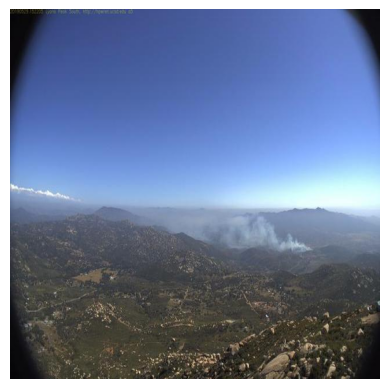

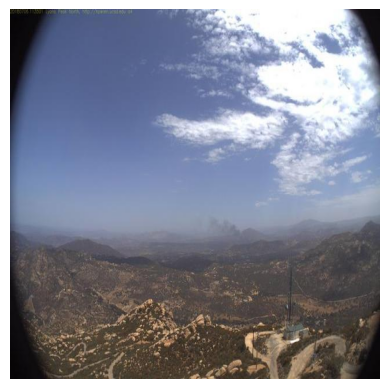

In [145]:
from PIL import Image
import io
import matplotlib.pyplot as plt
%matplotlib inline

# ... [previous code for loading and parsing the TFRecord]

# Function to decode and display an image
def display_image(image_raw):
    image = Image.open(io.BytesIO(image_raw))
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Iterate over the dataset and display images
for image_features in parsed_image_dataset.take(2):  # Adjust the number as needed
    image_raw = image_features['image/encoded'].numpy()
    display_image(image_raw)

In [92]:
!ls /content/downloaded_content/content/models/research/object_detection

anchor_generators	  export_inference_graph.py		   model_lib_tf1_test.py
box_coders		  export_tflite_graph_lib_tf2.py	   model_lib_tf2_test.py
builders		  export_tflite_graph_lib_tf2_test.py	   model_lib_v2.py
colab_tutorials		  export_tflite_graph_tf2.py		   model_main.py
configs			  export_tflite_ssd_graph_lib.py	   model_main_tf2.py
CONTRIBUTING.md		  export_tflite_ssd_graph_lib_tf1_test.py  models
core			  export_tflite_ssd_graph.py		   model_tpu_main.py
data			  g3doc					   packages
data_decoders		  inference				   predictors
dataset_tools		  __init__.py				   protos
dockerfiles		  inputs.py				   __pycache__
eval_util.py		  inputs_test.py			   README.md
eval_util_test.py	  legacy				   samples
exporter_lib_tf2_test.py  matchers				   test_data
exporter_lib_v2.py	  meta_architectures			   test_images
exporter_main_v2.py	  metrics				   tpu_exporters
exporter.py		  model_hparams.py			   utils
exporter_tf1_test.py	  model_lib.py


In [103]:
!ls /content/

content  cs249_final_content  downloaded_content  drive  models  sample_data  Wildfire


In [146]:
%cd /content/downloaded_content/content/models/research/object_detection


import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/drive/.shortcut-targets-by-id/16QMmZ9ZlGkezlY99PrUJr5JxALt9iftM/cs249_final_content/content/models/research/object_detection


In [152]:
import tensorflow as tf
import numpy as np
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Load the saved model
detection_model = tf.saved_model.load(PATH_TO_CKPT)

# Load the label map
num_classes = get_num_classes(PATH_TO_LABELS)
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy()
                   for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    output_dict['detection_masks'], output_dict['detection_boxes'],
                     image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [153]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

{'detection_classes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'detection_multiclass_scores': array([[0.00607959, 0.28497064],
       [0.00724833, 0.21224622],
       [0.00477236, 0.16806412],
       [0.00636946, 0.10675912],
       [0.00560326, 0.10313866],
       [0.00807915, 0.09484592],
       [0.0084644 , 0.09264568],
       [0.00493246, 0.09171481],
       [0.00555869, 0.09044819],
       [0.00407781, 0.07984968],
       [0.00526497, 0.06920296],
       [0.0069579 , 0.06774022],
       [0.00517333, 0.06771143],
       [0.00687595, 0.0618022 ],
       [0.00681116, 0.05695826],
       [0.00600078, 0.0533288 ],
       [0.00785148, 0.05251897],
       [0.0089303 , 0.0519249 ],
       [0.004060

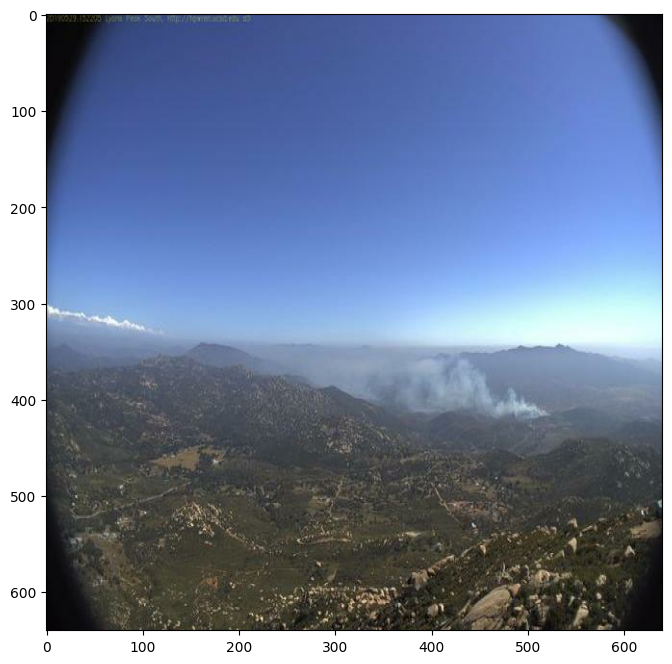

{'detection_classes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'detection_multiclass_scores': array([[0.00608487, 0.283752  ],
       [0.00724829, 0.21118543],
       [0.00477426, 0.1678109 ],
       [0.00637311, 0.1064864 ],
       [0.00560396, 0.10324946],
       [0.0080793 , 0.09467729],
       [0.00493547, 0.09143216],
       [0.00555712, 0.09052022],
       [0.00847255, 0.08969701],
       [0.00407944, 0.07967876],
       [0.0052617 , 0.06857762],
       [0.00696189, 0.0677177 ],
       [0.00517581, 0.06755579],
       [0.00688381, 0.06186275],
       [0.00681704, 0.0567524 ],
       [0.0060036 , 0.05321993],
       [0.00784805, 0.05258888],
       [0.00892231, 0.0517788 ],
       [0.004063

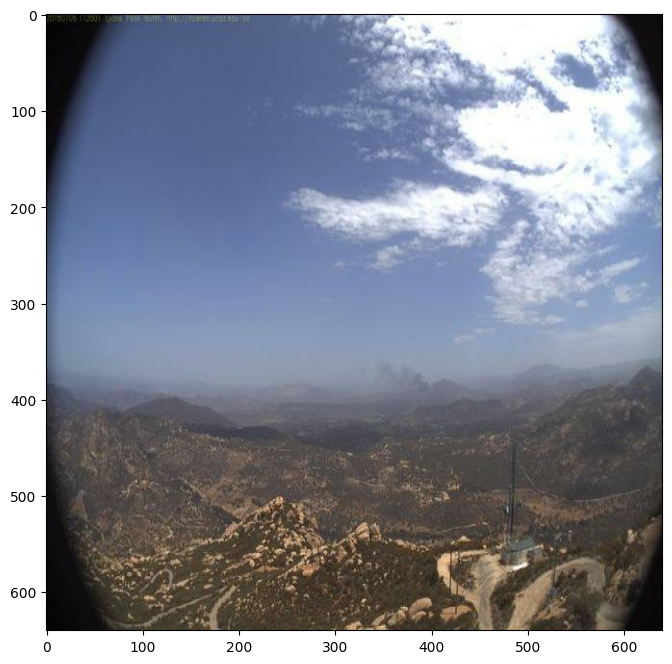

{'detection_classes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'detection_multiclass_scores': array([[0.00609945, 0.28144324],
       [0.00724835, 0.21211322],
       [0.00477145, 0.16796823],
       [0.00637262, 0.10639861],
       [0.00559766, 0.10350394],
       [0.00805957, 0.09534044],
       [0.00493848, 0.09125258],
       [0.00555748, 0.09027725],
       [0.00847454, 0.0893487 ],
       [0.00407041, 0.07983966],
       [0.00525769, 0.06860972],
       [0.0069771 , 0.06773516],
       [0.00519157, 0.06729736],
       [0.00689645, 0.06194657],
       [0.00680936, 0.05680616],
       [0.00599323, 0.05380622],
       [0.00784534, 0.05262277],
       [0.00892196, 0.05170823],
       [0.004061

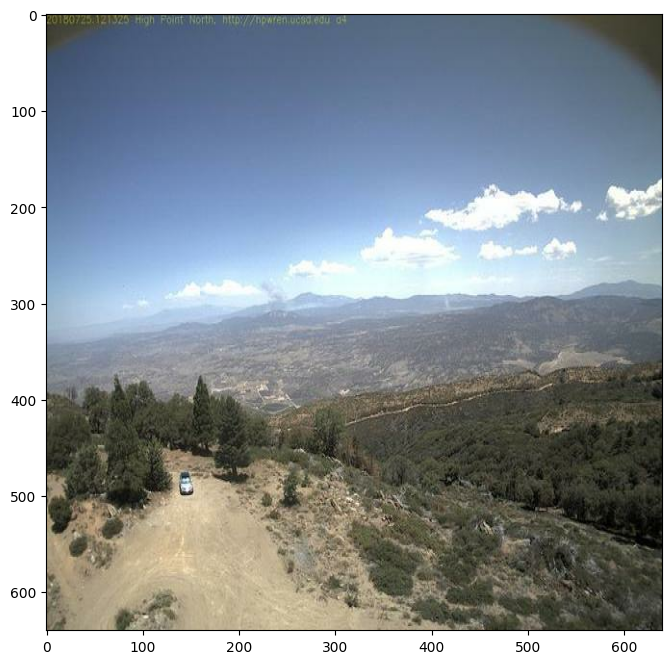

{'detection_classes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'detection_multiclass_scores': array([[0.00609463, 0.2825306 ],
       [0.00724872, 0.21253103],
       [0.00477104, 0.16801009],
       [0.00637153, 0.10632542],
       [0.00560212, 0.102908  ],
       [0.00805671, 0.09545102],
       [0.00493931, 0.09106187],
       [0.00847463, 0.09042995],
       [0.00556071, 0.09007367],
       [0.00406878, 0.07993166],
       [0.00526601, 0.0685034 ],
       [0.00697897, 0.06775174],
       [0.00518453, 0.06748372],
       [0.00688972, 0.06167049],
       [0.00680645, 0.05690003],
       [0.00599862, 0.05352829],
       [0.00784864, 0.05249043],
       [0.00892495, 0.05181114],
       [0.004060

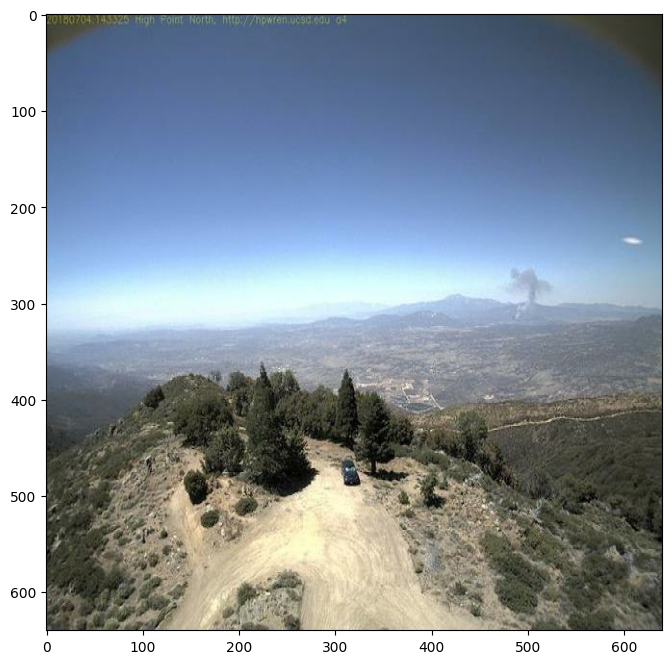

{'detection_classes': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'detection_multiclass_scores': array([[0.00609062, 0.28201324],
       [0.00724846, 0.21242538],
       [0.00476971, 0.16804317],
       [0.00637063, 0.10595831],
       [0.00559935, 0.10283075],
       [0.0080546 , 0.09580894],
       [0.00494505, 0.09067453],
       [0.00847431, 0.09010845],
       [0.00556332, 0.08970079],
       [0.00406457, 0.08022416],
       [0.00526449, 0.06860153],
       [0.00698438, 0.06775293],
       [0.0051887 , 0.06766039],
       [0.00689272, 0.06182094],
       [0.00680792, 0.05692403],
       [0.00599765, 0.05363308],
       [0.00785986, 0.05237174],
       [0.0089154 , 0.05141232],
       [0.004063

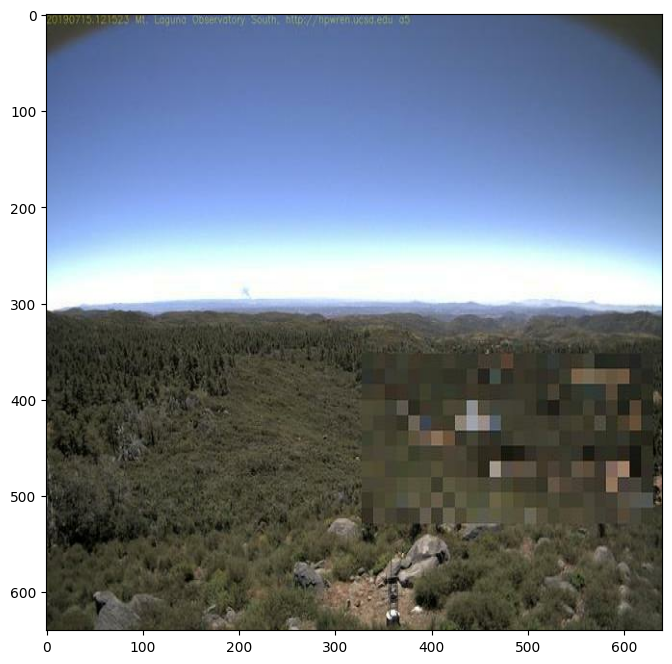

In [163]:
# Limited displayed images to 5 to reduce memory

def load_and_preprocess_image(parsed_data):
    image = tf.image.decode_image(parsed_data['image/encoded'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize and convert to float32

    # Resize the image to match the expected input size of the model
    # Replace (640, 640) with the actual expected size if different
    image = tf.image.resize(image, (640, 640))
    return image.numpy()


count = 5
for i, image_features in enumerate(parsed_image_dataset.take(count)):
    # Convert the parsed data into a numpy array
    image_np = load_and_preprocess_image(image_features)

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    # image_np_expanded = np.expand_dims(image_np, axis=0)
    # print(image_np_expanded.shape)

    # Actual detection
    output_dict = run_inference_for_single_image(detection_model, image_np)

    # Visualization of the results of a detection
    print(output_dict)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8)

    # Display the image
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()

# 3. Convert

With our model trained, it's time to convert our graph to .tflite!

In [ ]:
%ls /content/models/research/fine_tuned_model/tflite

In [ ]:
!tflite_convert \
  --input_shape=1,224,224,3 \
  --input_arrays=normalized_input_image_tensor \
  --output_arrays=MobilenetV1/Predictions/Softmax \
  --allow_custom_ops \
  --graph_def_file=/content/models/research/fine_tuned_model/tflite/tflite_graph.pb \
  --output_file="/content/models/research/fine_tuned_model/final_model.tflite"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter('/content/drive/MyDrive/final_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

In [ ]:
# Change the final TFLite destination here
!cp /content/models/research/fine_tuned_model/final_model.tflite "/content/drive/My Drive/"

Your TFLite file is now in your Drive as "final_model.tflite", ready to use with your project on-device! For specific device tutorials, check out the official TensorFlow Lite [Android Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), or [Raspberry Pi Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi). [link text](https://)